# 1 Initialization of environment

First, we have to activate the environment. The first run may take a while as external libraries will be downloaded and compiled. 

In [1]:
Pkg.activate(".")

In the solution, I use my own Julia library QuantumCircuits. It is available through the Julia package repository "Pkg" and sources are available on [GitHub](https://github.com/Adgnitio/QuantumCircuits.jl). A short tutorial is available in the notebook [02_QuantumCircuits](02_QuantumCircuits.ipynb).

In [2]:
using QuantumCircuits
using QuantumCircuits.QML
using QuantumCircuits.QCircuits.Qiskit
using QuantumCircuits.QCircuits.Qiskit: qiskit
using QuantumCircuits.QCircuits.Circuit
using QuantumCircuits.QCircuits.Circuit: toQiskit, getCode
using QuantumCircuits.QCircuits.Gates: CX
using QuantumCircuits.Execute: generate_mesuere_circuits, extractProbability, correctMeasures

# 2 Introduction

Our goal is to implement the Trotterization to evolve the specified state $|110\rangle$, under the specified Hamiltonian, for the specified duration $\pi$ but utilize as many Trotter steps as is possible. The algorithm, in principle, should be executed for any state, Hamiltonian, and duration.

Unfortunately on the current quantum computer, this is impossible regarding the noises. Therefore I've proposed an algorithm that can break the Trotterization into pieces with a shorter depth which can be executed on current quantum computers. The main points and requirements of the algorithm:
- It breaks the Trotterization into pieces with a shorter depth.
- It is convergent to the final state.
- The designed algorithm should allow us to find the simulated state for an arbitrary number of qubits.

The first stage is to find a way how to effectively implement a trotter step, the details of that can be found in the notebook [03_trotter_step](03_trotter_step.ipynb). 


# 3 The overview of algorithm

Let's assume, that we would like to implement an algorithm with 10 Trotter steps, but using at most 2 Trotter steps in single circuit execution. We can do this by implementing the circuit below and using the gradient descent method to find the parameters $\theta_1$ that minimize our cost function. The cost function is chosen that after finding the optimal parameters the output status is $|0\rangle_3$.

<img src="images/overview.jpg" width="500" height="500">

If the optimal parameters were found, the operator inverse of _**Ansact**_ transform the initial state into the state after the initialization and the two trotter steps. So the circuits on figure below are equivalent.


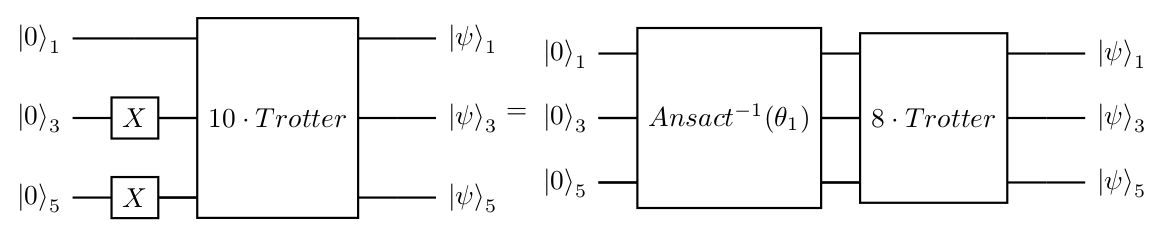

In the Figure below, you can find the ansact with 27 parameters used in the algorithm implementation.

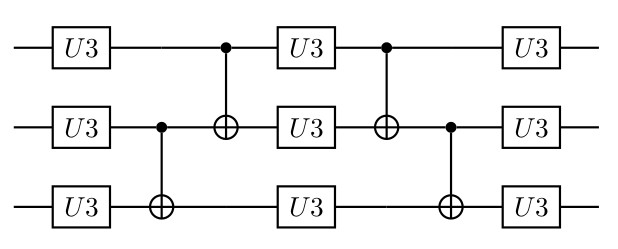

It is worth noting:
* We are not looking for parameters that implement the whole unitary matrix of the 2 Trotter steps with the greatest accuracy, but only a transformation for a specific input state. This implies that it is relatively easy to find these parameters. 
* Using the ansact, we can replace the circuit with 15 CNOT gates with the one with only 4 CNOT gates.

## 3.1 Next step
Then we do a similar step and try to find the parameters $\theta_2$ using the gradient descent method that make the circuit in the Figure below will finish at state $|0\rangle_3$.

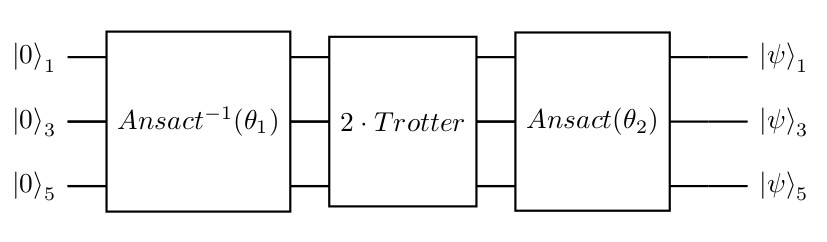

If the optimal parameters $\theta_2$ were found, the operator inverse of _**Ansact**_ transform the initial state into the state after the initialization and the 4 trotter steps. So the circuits on Figure below are equivalent.

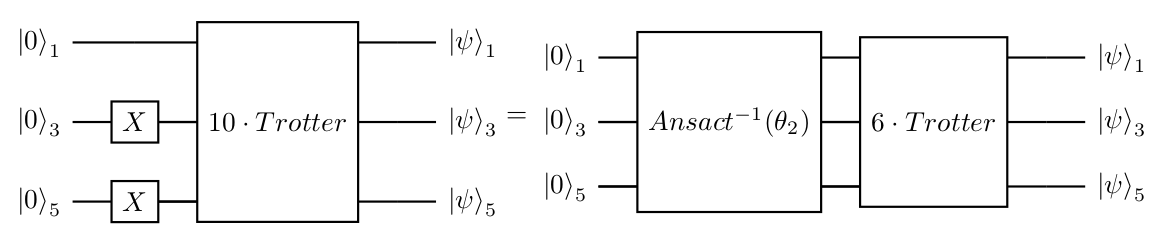

By continuing this algorithm finally, we can find the parameters which implement the whole Trotterization, see Figure below.

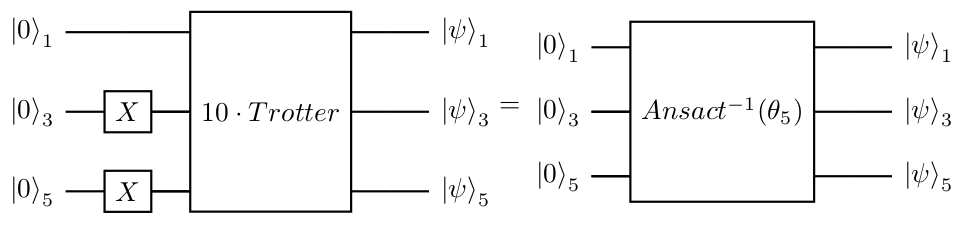

## 3.2 Result evaluation
I've evaluated the algorithm on the simulator with time set to $\frac{\pi}{4}$, $\frac{\pi}{2}$, $\frac{3\pi}{4}$, $\pi$ and it works fine. So this show that it will work not only for the special case where the whole circuit is identity. The evaluation can be found in the notebook [04_algorithm_evaluation](04_algorithm_evaluation.ipynb)

## 3.3 Trening
I've also find the parameters $\theta_1$ of the first step on quantum computer (ibm jakarta).The parameter for steps from 2 to 5 ($\theta_2, \theta_3, \theta_3, \theta_5$) was found on the noisy quantum simulator (as was discussed with AJ). Description of the process of finding the parameter is described in a notebook [05_trening](05_trening.ipynb).

# 4 Execute on the real device
First, we need the ansact.

In [3]:
function generate_ansact()
    n = 3
    qr = QuantumRegister(7, "q")
    qc = QCircuit(qr)
    qr = [qr[1], qr[3], qr[5]]

    qc.u3(qr)
    for i in (n-2):-1:0
        i = i+1
        qc.cx(qr[i], qr[i+1])
        #qc.rzx(qr[i], qr[i+1])
    end
    qc.u3(qr)
    for i in 0:(n-2)
        i = i+1
        qc.cx(qr[i], qr[i+1])
        #qc.rzx(qr[i], qr[i+1])
    end
    qc.u3(qr)

    return qc
end

generate_ansact (generic function with 1 method)

The next function generates the empty circuit, it is a utility function.

In [4]:
function generate_empty_circuit(;init=false)
    qr = QuantumRegister(7, "q")
    qc = QCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    if init
        qc.x([3, 5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    end

    return qc
end

generate_empty_circuit (generic function with 1 method)

We set the parameters that were found during the training. Description of the process of finding the parameter is described in a notebook [05_trening](05_trening.ipynb)

In [5]:
start_params = [1.103633523141456, 0.5621723387373332, 3.535362761806341, 3.1465964893594798, 0.2416797028860025, 3.7901137174699655, 2.515512466095495, 6.762078821484598, 5.187907546418758, -0.19860568802167688, 5.997524383569426, 5.905306784345511, 6.0845429036054846, 3.1437960954072843, 4.530029341809641, 1.2337272277202151, 2.221508726842684, 1.6606762213540665, 4.12874467494519, 4.827888262840575, 5.603301739361324, 5.894694449973559, 1.4978959576376278, 6.261167575543967, 2.7695944642836734, 1.8088920099024433, 1.9134833740486716]

27-element Vector{Float64}:
  1.103633523141456
  0.5621723387373332
  3.535362761806341
  3.1465964893594798
  0.2416797028860025
  3.7901137174699655
  2.515512466095495
  6.762078821484598
  5.187907546418758
 -0.19860568802167688
  5.997524383569426
  5.905306784345511
  6.0845429036054846
  ⋮
  1.2337272277202151
  2.221508726842684
  1.6606762213540665
  4.12874467494519
  4.827888262840575
  5.603301739361324
  5.894694449973559
  1.4978959576376278
  6.261167575543967
  2.7695944642836734
  1.8088920099024433
  1.9134833740486716

Next, we generate the empty ansact, and set the found parameters.

In [6]:
tmp_ansact = generate_ansact()
setparameters!(tmp_ansact, start_params)

According to the algorithm, our solution is the inverse of the ansact. 

In [7]:
tmp_qc_full = generate_empty_circuit()
append!(tmp_qc_full, inv(tmp_ansact))
tmp_qc_full

                                                                        »
q_0: ───────────────────────────────────────────────────────────────────»
     ┌─────────────────────────────┐                                    »
q_1: ┤ U3(-1.2337,-1.6607,-2.2215) ├────────────────────■───────────────»
     └─────────────────────────────┘                    │               »
q_2: ───────────────────────────────────────────────────┼───────────────»
     ┌─────────────────────────────┐                  ┌─┴─┐             »
q_3: ┤ U3(-5.8947,-6.2612,-1.4979) ├──■───────────────┤ X ├─────────────»
     └─────────────────────────────┘  │               └───┘             »
q_4: ─────────────────────────────────┼─────────────────────────────────»
     ┌─────────────────────────────┐┌─┴─┐┌─────────────────────────────┐»
q_5: ┤ U3(-2.7696,-1.9135,-1.8089) ├┤ X ├┤ U3(-4.1287,-5.6033,-4.8279) ├»
     └─────────────────────────────┘└───┘└─────────────────────────────┘»
q_6: ─────────────────────────────────

We have to create a function to do the tomography circuits.

In [8]:
function prepare_tomography_qc(qc)
    qqc = toQiskit(qc)

    qqr = getQRegister(qqc, "q")
    chec_qubits = [get(qqr, 1), get(qqr, 3), get(qqr, 5)]
    nqqc = qiskit.ignis.verification.tomography.state_tomography_circuits(qqc.qc, chec_qubits)

    return nqqc
end

prepare_tomography_qc (generic function with 1 method)

Next, we prepare the tomography circuits.

In [9]:
evaluate_qc_step5 = prepare_tomography_qc(tmp_qc_full)

27-element Vector{PyCall.PyObject}:
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d0100>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d0220>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d0610>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d09a0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d0d90>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d0eb0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d0ac0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d6940>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d6d00>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d6e20>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0de98d6a60>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object

For final submission, we need to execute a solution on a real backend with 8 repetitions. For this, we need to import the Python code which does this execution. In the eval.jl file is embedded python functions used in challenge notebook.

In [10]:
include("src/Challenge/eval.jl")

evaluate (generic function with 1 method)

Now, we need to load our accounts and used devices.

In [11]:
qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub="ibm-q-community", group="ibmquantumawards", project="open-science-22")

jakarta = provider.get_backend("ibmq_jakarta")
# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = qiskit.providers.aer.QasmSimulator.from_backend(provider.get_backend("ibmq_jakarta"))
# Noiseless simulated backend
sim = qiskit.providers.aer.QasmSimulator()

PyObject QasmSimulator('qasm_simulator')

In [12]:
@enum ExecutePlace NoisySim RealDevice PreviouslyJobs
#useExecutePlace = NoisySim
useExecutePlace = PreviouslyJobs

PreviouslyJobs::ExecutePlace = 2

In [13]:
if useExecutePlace == NoisySim
    # Use this if you would like to execute on noisy simulator
    jobs_step5 = evaluate_jobs(evaluate_qc_step5, sim_noisy_jakarta)
elseif useExecutePlace == RealDevice
    # Use this if you would like to execute on real device, jakarta
    jobs_step5 = evaluate_jobs(evaluate_qc_step5, jakarta)
elseif useExecutePlace == PreviouslyJobs
    # Use this if you would like to load jobs from previously executed jobs.
    jobsid_step5 = ["6230d605d73e0a4b4a31ff7c", "6230d609d10f746d4467ae33", "6230d60c74a4dc7a8535b5ae",
                    "6230d610d10f74540667ae34", "6230d6122001bb71d86e9827", "6230d6150d6e0d97d1138696",
                    "6230d618314f79a95e20c20d", "6230d61b0d6e0d4cd6138697"]
    jobs_step5 = [jakarta.retrieve_job(id) for id in jobsid_step5]
else
    println("ERROR")
end

8-element Vector{PyObject}:
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82050bb0>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82050dc0>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82a6d160>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82050e80>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82050d30>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82059760>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82059370>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d82059790>

In [14]:
results_step5 = evaluate_results(jobs_step5, evaluate_qc_step5)

(0.7975091601169371, 0.011794318866976355)

After executing the simulation on the real device we have the fidelity result equal to **0.7975**. But we can do better, I've combined the methods "Zero Noise Extrapolation" and "Measurement Error Mitigation" and this allows us to achieve the fidelity scale equal to **0.9241**.

## 4.1 Zero Noise Extrapolation

I used the _FIIM_ method described in the articles below. 
* _"Resource Efficient Zero Noise Extrapolation with Identity Insertions"_ (https://arxiv.org/abs/2003.04941)
* _"Computationally Efficient Zero Noise Extrapolation for Quantum Gate Error Mitigation"_ (https://arxiv.org/abs/2110.13338)

So first I've replaced all CX gates with 3 CX gates and after executing the original and new circuits I use the following extrapolation.

$\langle M \rangle_{ex} = \frac{3}{2}\langle M \rangle(1) - \frac{1}{2}\langle M \rangle(3) $

First, we need to create a function that generates a new, equivalent for a given input circuit, by replacing one CX gate with three. 

In [15]:
function generate_3cx_circuit(qc)
    newQC = generate_empty_circuit()
    for c in getCode(qc)
        if typeof(c) == CX
            add!(newQC, c)
            newQC.barrier()
            add!(newQC, c)
            newQC.barrier()
            add!(newQC, c)
        else
            add!(newQC, c)
        end
    end

    return newQC
end

generate_3cx_circuit (generic function with 1 method)

We also need a function that calculates the probability from the measured counts.

In [16]:
function extractProbability2(counts::Dict, qubits::Integer, shots::Integer)
    p = zeros(2^qubits)

    for (k, n) in counts
        k = k[3:end]
        p[parse(Int, k; base=16) + 1] = n/shots
    end

    return p
end


extractProbability2 (generic function with 1 method)

Now we generate a new circuit by replacing one CX gate with three. 

In [17]:
tmp_qc_full = generate_empty_circuit()
append!(tmp_qc_full, inv(tmp_ansact))
tmp_qc_full_3cx = generate_3cx_circuit(tmp_qc_full)

                                          ░       ░            ░       ░      »
q_0: ─────────────────────────────────────░───────░────────────░───────░──────»
     ┌─────────────────────────────┐      ░       ░            ░       ░      »
q_1: ┤ U3(-1.2337,-1.6607,-2.2215) ├──────░───────░────────■───░───■───░───■──»
     └─────────────────────────────┘      ░       ░        │   ░   │   ░   │  »
q_2: ─────────────────────────────────────░───────░────────┼───░───┼───░───┼──»
     ┌─────────────────────────────┐      ░       ░      ┌─┴─┐ ░ ┌─┴─┐ ░ ┌─┴─┐»
q_3: ┤ U3(-5.8947,-6.2612,-1.4979) ├──■───░───■───░───■──┤ X ├─░─┤ X ├─░─┤ X ├»
     └─────────────────────────────┘  │   ░   │   ░   │  └───┘ ░ └───┘ ░ └───┘»
q_4: ─────────────────────────────────┼───░───┼───░───┼────────░───────░──────»
     ┌─────────────────────────────┐┌─┴─┐ ░ ┌─┴─┐ ░ ┌─┴─┐      ░       ░      »
q_5: ┤ U3(-2.7696,-1.9135,-1.8089) ├┤ X ├─░─┤ X ├─░─┤ X ├──────░───────░──────»
     └─────────────────────────────┘└───

Next, we prepare the tomography circuits.

In [18]:
evaluate_qc_step5_3cx = prepare_tomography_qc(tmp_qc_full_3cx)

27-element Vector{PyObject}:
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8036d3d0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8036d4f0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8036d8e0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8036dc70>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8036dd90>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8036da00>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80369880>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80369c10>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80369d30>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d803699a0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80358760>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7

In [19]:
if useExecutePlace == NoisySim
    # Use this if you would like to execute on noisy simulator
    jobs_step5_3cx = evaluate_jobs(evaluate_qc_step5_3cx, sim_noisy_jakarta)
elseif useExecutePlace == RealDevice
    # Use this if you would like to execute on real device, jakarta
    jobs_step5_3cx = evaluate_jobs(evaluate_qc_step5_3cx, jakarta)
elseif useExecutePlace == PreviouslyJobs
    # Use this if you would like to load jobs from previously executed jobs.
    jobsid_step5_3cx = ["6241f54e19e689dcb0c824b2", "6241f553537fcced289eb942", "6241f55609995c6fc4494046",
                        "6241f55819e689a092c824b3", "6241f55b8293e96dfd1e7493", "6241f55e537fcc03189eb944",
                        "6241f561a2f72d4c77dacc19", "6241f5640af65dc784d94a94"]
    jobs_step5_3cx = [jakarta.retrieve_job(id) for id in jobsid_step5_3cx]
else
    println("ERROR")
end

8-element Vector{PyObject}:
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d8036d130>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d80399af0>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d8036d1f0>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d8036d160>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d80318ee0>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d80318be0>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d80318fd0>
 PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d80318850>

We can check that the fidelity of the new circuit is worse than the original one.

In [20]:
results_step5_3cx = evaluate_results(jobs_step5_3cx, evaluate_qc_step5_3cx)

(0.5805340085139745, 0.017288570651503198)

## 4.2 Measurement Error Mitigation

First, to improve our results we use the method described in https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html.

The circuit used in tomography doesn't contain the measures, so we add them.  This is needed for generate_mesuere_circuits method because it uses the measrments to calculate the measurement matrix.

In [21]:
tmp_qc_full2 = generate_empty_circuit()
cr = ClassicalRegister(3)
setClassicalRegister!(tmp_qc_full2, cr)
tmp_qc_full2.measure([1, 3, 5], [0, 1, 2])
tmp_qc_full2
# Please note, that after adding the measurements tmp_qc_full circuit cannot be used to generate tomography.

               
 q_0: ─────────
      ┌─┐      
 q_1: ┤M├──────
      └╥┘      
 q_2: ─╫───────
       ║ ┌─┐   
 q_3: ─╫─┤M├───
       ║ └╥┘   
 q_4: ─╫──╫────
       ║  ║ ┌─┐
 q_5: ─╫──╫─┤M├
       ║  ║ └╥┘
 q_6: ─╫──╫──╫─
       ║  ║  ║ 
c2: 3/═╩══╩══╩═
       0  1  2 

Now, we can generate the necessary circuits to calculate the measures error matrix.

In [22]:
measure_Corr = generate_mesuere_circuits(tmp_qc_full2)

8-element Vector{QiskitCircuit}:
                
 q_0: ─────────
      ┌─┐      
 q_1: ┤M├──────
      └╥┘      
 q_2: ─╫───────
       ║ ┌─┐   
 q_3: ─╫─┤M├───
       ║ └╥┘   
 q_4: ─╫──╫────
       ║  ║ ┌─┐
 q_5: ─╫──╫─┤M├
       ║  ║ └╥┘
 q_6: ─╫──╫──╫─
       ║  ║  ║ 
c3: 3/═╩══╩══╩═
       0  1  2 
                  
 q_0: ───────────
      ┌───┐   ┌─┐
 q_1: ┤ X ├───┤M├
      └───┘   └╥┘
 q_2: ─────────╫─
       ┌─┐     ║ 
 q_3: ─┤M├─────╫─
       └╥┘     ║ 
 q_4: ──╫──────╫─
        ║  ┌─┐ ║ 
 q_5: ──╫──┤M├─╫─
        ║  └╥┘ ║ 
 q_6: ──╫───╫──╫─
        ║   ║  ║ 
c4: 3/══╩═══╩══╩═
        1   2  0 
                  
 q_0: ───────────
           ┌─┐   
 q_1: ─────┤M├───
           └╥┘   
 q_2: ──────╫────
      ┌───┐ ║ ┌─┐
 q_3: ┤ X ├─╫─┤M├
      └───┘ ║ └╥┘
 q_4: ──────╫──╫─
       ┌─┐  ║  ║ 
 q_5: ─┤M├──╫──╫─
       └╥┘  ║  ║ 
 q_6: ──╫───╫──╫─
        ║   ║  ║ 
c5: 3/══╩═══╩══╩═
        2   0  1 
                  
 q_0: ───────────
      ┌───┐┌─┐   
 q_1: ┤ X ├┤M├───
      └

In [23]:
# Convert the vector of circuit to Qiskit (Python) object.s
measure_Corr_qiskit = [c.qc for c in measure_Corr]

8-element Vector{PyObject}:
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80345550>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d803454c0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80345310>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80345eb0>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d801f5a00>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8020a580>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d8020ad00>
 PyObject <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f0d80207190>

In [24]:
if useExecutePlace == NoisySim
    # Use this if you would like to execute on noisy simulator
    jobs_meas_corr = qiskit.execute(measure_Corr_qiskit, sim_noisy_jakarta, shots=8192)
elseif useExecutePlace == RealDevice
    # Use this if you would like to execute on real device, jakarta
    jobs_meas_corr = qiskit.execute(measure_Corr_qiskit, jakarta, shots=8192)
elseif useExecutePlace == PreviouslyJobs
    # Use this if you would like to load jobs from previously executed jobs.
    jobs_meas_corr = jakarta.retrieve_job("62420af774de0e045a85c61e")
else
    println("ERROR")
end    

PyObject <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x7f0d80207c10>

Now we can calculate the mitigation matrix.

In [25]:
function createCorrMatrix(jobs, shots=8192)
    job_results = jobs.result().get_counts()
    results = Vector{Float64}[]
    for res in job_results
        push!(results, extractProbability(res, 3, shots))
    end
    corrMes = hcat(results...)
    correctMeas = inv(corrMes)

    return correctMeas
end

createCorrMatrix (generic function with 2 methods)

In [26]:
corrMatrix = createCorrMatrix(jobs_meas_corr)

8×8 Matrix{Float64}:
  1.09129      -0.10833      -0.0401371    …   0.00152559  -0.000145745
 -0.0614535     1.13586       0.00260116      -7.52259e-5   0.00242505
 -0.00661344    0.000424581   1.11089         -0.0493393    0.00606485
  0.000409404  -0.00729659   -0.0549041        0.00270269  -0.05178
 -0.0250862     0.00218803    0.00050769      -0.0456883    0.00545616
  0.00130855   -0.0230916     3.6756e-5    …   0.00125427  -0.0460079
  0.000141515  -1.2969e-5    -0.0195867        1.14503     -0.11412
  2.62173e-6    0.000260397   0.000594052     -0.0554141    1.19811

## 4.3 Combine of two methods.

The algorithm for combining the methods _"Zero Noise Extrapolation"_ and _"Measurement Error Mitigation"_ is quite simple.
For each of 8 jobs run we iterate by tomography circuits. So for each iteration, we have two results counts one from the original circuit and the second for 3 CX.
* First, we mitigate the measurement error by multiplying the probability vector by the mitigation matrix for both circuits - _"Measurement Error Mitigation"_.
* Then we use equation $\langle M \rangle_{ex} = \frac{3}{2}\langle M \rangle(1) - \frac{1}{2}\langle M \rangle(3) $ to do the _"Zero Noise Extrapolation"_.

After calculating the mitigated probability vector we convert the probability into a counts dictionary and store this in the job result.

In [27]:
int(x) = floor(Int, x)

# zero nois - correct meaurment
# For all jobs
for (j, j3cx) in zip(jobs_step5, jobs_step5_3cx)    
    # For all circuits in job
    for (res, res3cx) in zip(j.result().results, j3cx.result().results)
        counts = res.data.counts
        counts_3cx = res3cx.data.counts

        # Extract probability
        p = extractProbability2(counts, 3, res.shots)
        p_3cx = extractProbability2(counts_3cx, 3, res3cx.shots)

        # Mittigate the measurnes
        cp = correctMeasures(corrMatrix, p)
        cp_3cx = correctMeasures(corrMatrix, p_3cx)

        # Caclulate Zero Noise Extrapolation
        new_p = (3/2) * cp - (1/2) * cp_3cx
        
        # Correct values below 0 and abowe 1.
        new_p = min.(max.(new_p, 0.0), 1.0)
        new_p = new_p / sum(new_p)

        # Calculate new counts
        cp = int.(round.(1000_000 .* new_p))

        # Save the results
        new_counts = Dict()
        shots = 0
        for (i, v) in enumerate(cp)
            push!(new_counts, string("0x", (i-1)) => v )
            shots += v
        end

        res.data.counts = new_counts
        res.shots = shots
    end
end

In [28]:
results_step5 = evaluate_results(jobs_step5, evaluate_qc_step5)

(0.9241462156154776, 0.00347800242121078)